In [1]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn

import sklearn.pipeline 
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network

from sklearn.preprocessing import StandardScaler

import gensim.models 

from scipy import stats
import statsmodels.stats.multicomp as mc

from statannotations.Annotator import Annotator

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16}) #default font sizes for plots

In [3]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/tutorial_HMEC/'

# MPRA data

We are going to predict data from a massively parallel reporter assay (MPRA) study (Griesemer et al. 2021):

<img src="https://pbs.twimg.com/media/Ers7U2YVgAI-BDG?format=jpg&name=large" width=70% />

We will treat Ref and Alt seqeunces independently and predict reporter expression in HMEC cells for each seqeunce using regression methods.

In [4]:
mpra_df = pd.read_csv(data_dir + 'mpra_HMEC.csv') #sequence info

In [5]:
mpra_df.head()

,seq,group,Expression
0,GTGGCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCT...,ARHGEF12,0.033228
1,GTGGCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCT...,ARHGEF12,0.145253
2,GCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCTTCC...,ARHGEF12,0.263987
3,GCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCTTCC...,ARHGEF12,0.303280
4,ACATACTAAATAGCAGGCACTTGAAAATGGGTGTGTTTTCTTCCAT...,ARHGEF12,-0.931812


In [6]:
len(mpra_df)

14970

Text(0, 0.5, 'counts')

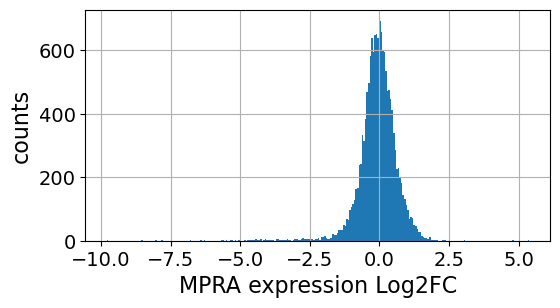

In [7]:
ax = mpra_df.Expression.hist(bins='auto',figsize=(6,3))

ax.set_xlabel('MPRA expression Log2FC')
ax.set_ylabel('counts')

The predictions will be based on embeddings, obtained for each seqeunce via a masked language model (MLM) (Gankin et al. 2023). MLM is an unsupervised model which we specifically retrained to reconstruct masked nucleotides in DNA seqeunces of mammalian 3'UTR regions. 

<img src="https://pbs.twimg.com/media/FntnrCzXgAEUMh3?format=jpg&name=medium" width=70% />

In [8]:
mlm_embeddings = np.load(data_dir + "mpra_MLM.npy") #masked language model embeddings

# Compare regression algorithms

We will first compare a few common machine learning regression algorithms: Ridge (L2) regression, multilayer perceptron (MLP), and support vector regression (SVR). 

Nested Cross-Validation is a common approach to compare different machine-learning algorithms. 
The outer loop serves to estimate the algorithm performance and the inner loop is used to tune hyper-parameters.
When the best performing algorithm is chosen,  hyperparameter tuning is performed again in a single CV loop over the whole available data. The final model is then obtained via training with the resulting hyperparamaters on all the data. To report the estimated performance, the score obtained at the 1st step with the Nested CV can be used.

<img src="https://hackingmaterials.lbl.gov/automatminer/_images/cv_nested.png" width=70% />

In [9]:
class GroupNestedCV():
    
    '''
    Group Nested Cross-Validation
    
    Parameters:
    clf: sklearn-compatible classifier
    hpp_search_grid: dictionary of parameter values for hyperparameter search
    
    if hpp_search_grid is None, just perform Group k-fold CV
    '''
    
    def __init__(self, clf, hpp_search_grid=None, n_splits = 10):
        
        self.clf = clf
        self.hpp_search_grid = hpp_search_grid
        self.group_kfold = sklearn.model_selection.GroupKFold(n_splits=n_splits)
        
    def run(self, X, y, groups):
    
        '''
        Iterates over  self.group_kfold folds and performs hyperparameter search within each fold

        Returns:
        Predictions for all folds
        '''

        kfold_scores = [] #predictions in all folds

        #outer loop
        for fold_idx, (train_idx, test_idx) in enumerate(self.group_kfold.split(X, y, groups)):

            X_train, y_train, groups_train = X[train_idx,:], y[train_idx], groups[train_idx]

            X_test, y_test = X[test_idx,:], y[test_idx]

            if self.hpp_search_grid!=None:

                print(f'Hyperparameter search in fold {fold_idx}')

                gs = sklearn.pipeline.make_pipeline(StandardScaler(),
                                                sklearn.model_selection.GridSearchCV(self.clf, self.hpp_search_grid, cv=3))

                gs.fit(X_train, y_train, gridsearchcv__groups = groups_train)

                best_params = gs['gridsearchcv'].best_params_
                print(f'Best hyperparameters: {best_params}')

            #train 
            pipe = sklearn.pipeline.make_pipeline(StandardScaler(), self.clf)
            pipe.fit(X_train, y_train)
            
            #inference
            y_pred = pipe.predict(X_test)

            kfold_scores.append(np.vstack(([fold_idx]*len(y_test),y_pred,y_test))) #add predictions for the current fold

        return kfold_scores

In [10]:
algs = {} #algorithms to test
hpp_search_space = {} #hyperparameter search space for each model

algs['ridge'] = sklearn.linear_model.Ridge()
hpp_search_space['ridge'] = {'alpha':10.**np.arange(-10,10)}
              
algs['MLP'] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=10, 
                 batch_size=1000, learning_rate_init=5e-4, max_iter=500, shuffle=False)

algs['SVR'] = sklearn.svm.SVR(C=4, epsilon=0.1)

In [11]:
X = mlm_embeddings #MLM embeddings
y = mpra_df['Expression'].values #dependent variable
groups = mpra_df['group'].values #groups (genes)

In [12]:
preds_mpra = []

for model, alg in algs.items():
    
    print(f'MODEL: {model}')
    
    group_nested_cv = GroupNestedCV(alg, hpp_search_space.get(model,None), )
    
    scores = group_nested_cv.run(X, y, groups)
    
    scores = pd.DataFrame(np.hstack(scores).T, columns=['fold','y_pred','y_test']) #numpy array to DataFrame
    
    scores['model'] = model #add model column
    
    preds_mpra.append(scores)#stack dataframes of different models

preds_mpra = pd.concat(preds_mpra)#concatenate dataframes

MODEL: ridge
Hyperparameter search in fold 0
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 1
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 2
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 3
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 4
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 5
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 6
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 7
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 8
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 9
Best hyperparameters: {'alpha': 100.0}
MODEL: MLP
MODEL: SVR


In [13]:
preds_mpra

,fold,y_pred,y_test,model
0,0.0,-0.526315,0.101798,ridge
1,0.0,-0.475818,-0.237751,ridge
2,0.0,-0.461430,-0.183660,ridge
3,0.0,-0.525686,-0.475822,ridge
4,0.0,0.191575,0.693005,ridge
...,...,...,...,...
14965,9.0,-0.181854,-0.798085,SVR
14966,9.0,0.074127,0.029363,SVR
14967,9.0,0.019421,0.225314,SVR
14968,9.0,0.064456,-0.209163,SVR


In [14]:
per_fold_scores = preds_mpra.groupby(['model','fold']).apply(lambda x: sklearn.metrics.r2_score(x.y_test,x.y_pred)).rename('score').reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLP vs. SVR: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.754e-01 Stat=1.600e+01
SVR vs. ridge: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLP vs. ridge: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.906e-03 Stat=1.000e+00


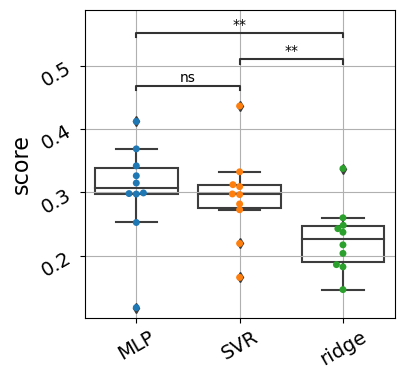

In [15]:
fig, ax = plt.subplots(figsize=(4,4))

ax = sns.swarmplot(data=per_fold_scores, x="model", y="score") #scatter plot
ax = sns.boxplot(data=per_fold_scores, x="model", y="score", boxprops={'facecolor':'None'})

box_pairs=[ ("MLP", "SVR"), ("MLP", "ridge"), ("SVR", 'ridge')]

annotator = Annotator(ax, box_pairs, data=per_fold_scores, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("score")
ax.tick_params(rotation=30)
ax.grid()

An alternatlive way to compare models: pool predictions from all CV folds and pretend that they are obtained from a single test set.
Then the error for each model and each observation is computed. Afterwards, a statistical test is preformed to determine if the average error from one model is greater than the average error from another model.

In [16]:
preds_mpra['error'] = abs(preds_mpra.y_pred-preds_mpra.y_test) #absolute errors for each observation

In [17]:
preds_mpra.groupby('model').error.mean()

model
MLP      0.372305
SVR      0.366511
ridge    0.390194
Name: error, dtype: float64

In [18]:
comp1 = mc.MultiComparison(preds_mpra['error'], preds_mpra['model'])
tbl, a1, a2 = comp1.allpairtest(stats.wilcoxon, method= "bonf")

tbl

group1,group2,stat,pval,pval_corr,reject
MLP,SVR,54174220.5,0.0005,0.0014,True
MLP,ridge,50952748.5,0.0,0.0,True
SVR,ridge,50152500.0,0.0,0.0,True


<span style="color:coral">Q: Which assumption is violated when performing such tests?</span>

Dietterich, Thomas G. "Approximate statistical tests for comparing supervised classification learning algorithms." Neural computation 10.7 (1998): 1895-1923.

# Comparing with other embeddings

We shall also try to predict MPRA expression from alternative embeddings: 4-mer counts and a Word2Vec model.

For this, we need to define some utility functions.

In [19]:
class Kmerizer:
    '''
    Helper class to generate k-mers and Word2Vec embeddings
    '''
    
    def __init__(self, k):
        
        self.k = k
        
        #generate all possible k-mers, e.g. 
        self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))} 
        
    def kmerize(self, seq):
        '''
        Count all k-mers in the sequence 
        Returns:
        A list with counts corresponding to each possible k-mer from self.kmers
        e.g. for k=2 and seq='ACTAC'
        > [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
        '''
        counts = [0]*4**self.k
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            counts[self.kmers[kmer]] += 1
        return counts
    
    def tokenize(self, seq):
        '''
        Get all k-mers in the sequence
        Returns:
        A list of all k-mers
        e.g. for 2-mers and seq='ACTAC' 
        > ['AC', 'CT', 'TA', 'AC']
        '''
        kmers = []
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
        return kmers

In [20]:
def word2vec_model(mpra_df):
    
    '''
    Word2Vec model
    
    k-mers are defined through their context: 
    k-mers with similar context will have similar embeddings
    '''
    
    kmerizer_w2v = Kmerizer(k=4)
    
    w2v_model = gensim.models.Word2Vec(sentences=mpra_df.seq.apply(lambda x: kmerizer_w2v.tokenize(x)), 
                         vector_size=128, window=5, min_count=1, workers=4, sg=1) #default: CBOW

    word2vec_emb = mpra_df.seq.apply(
        lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x)],axis=0)) #average embedding of all 4-mers in the sequence

    X = np.stack(word2vec_emb,axis=0)
    
    return X

In [21]:
data_matrices = {} #embeddings dictionary

data_matrices['MLM'] = mlm_embeddings

kmerizer4 = Kmerizer(k=4)
data_matrices['4-mers'] = np.stack(mpra_df.seq.apply(lambda x: kmerizer4.kmerize(x))) 

data_matrices['Word2Vec'] = word2vec_model(mpra_df)

y = mpra_df['Expression'].values
groups = mpra_df['group'].values

In [22]:
alg = sklearn.svm.SVR(C=4, epsilon=0.1)

preds_mpra = []

for model, X in data_matrices.items():
    
    print(f'MODEL: {model}')
    
    group_nested_cv = GroupNestedCV(alg)
    
    scores = group_nested_cv.run(X, y, groups)
    
    scores = pd.DataFrame(np.hstack(scores).T, columns=['fold','y_pred','y_test']) #numpy array to DataFrame
    
    scores['model'] = model #add model column
    
    preds_mpra.append(scores)#stack dataframes of different models

preds_mpra = pd.concat(preds_mpra)

MODEL: MLM
MODEL: 4-mers
MODEL: Word2Vec


In [23]:
per_fold_scores = preds_mpra.groupby(['model','fold']).apply(lambda x: sklearn.metrics.r2_score(x.y_test,x.y_pred)).rename('score').reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4-mers vs. MLM: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLM vs. Word2Vec: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.367e-02 Stat=4.000e+00
4-mers vs. Word2Vec: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.223e-01 Stat=1.700e+01


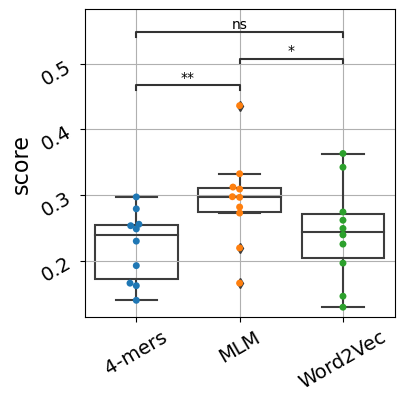

In [24]:
fig, ax = plt.subplots(figsize=(4,4))

ax = sns.swarmplot(data=per_fold_scores, x="model", y="score") #scatter plot
ax = sns.boxplot(data=per_fold_scores, x="model", y="score", boxprops={'facecolor':'None'})

box_pairs=[ ("MLM", "4-mers"), ("MLM", "Word2Vec"), ("4-mers", "Word2Vec")]

annotator = Annotator(ax, box_pairs, data=per_fold_scores, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("score")
ax.tick_params(rotation=30)
ax.grid()

# Assessing model stability

For a stable model, predictions are robust with respect to small changes in the train set (e.g. when including/excluding individual train instances).

To assess model stability, one performs repeated Cross-Validation: at each round the dataset is split into the same number of folds, but the exact fold composition is different. Then variance in predictions for each test point are estimated.

Example for classification (https://stats.stackexchange.com/questions/551242):

<img src="https://i.stack.imgur.com/vqyGM.png" width=70% />

In [33]:
X = mlm_embeddings
y = mpra_df['Expression'].values
groups = mpra_df['group'].values

pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
                     sklearn.linear_model.Ridge(alpha=100)) 

#pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
#                     sklearn.svm.SVR(C=4, epsilon=0.1))

#pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
#                sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=10, batch_size=1000, learning_rate_init=5e-4, max_iter=500, shuffle=False))

N_rounds = 20 #number of CV rounds
N_splits = 10 #number of CV splits in each round

N_instances = len(y) #total number of test points equals dataset size

cv_res = np.zeros((N_rounds*N_splits,N_instances)) #CV predictions for each point
cv_res[:] = np.NaN 

cv_scores = [] # score for each fold in each round, N_rounds X N_splits

for round_idx in range(N_rounds):
    
    print(f'CV round {round_idx}')

    gss = sklearn.model_selection.GroupShuffleSplit(n_splits=N_splits, train_size=.9, random_state = round_idx) #10-fold CV

    for fold_idx, (train_idx, test_idx) in enumerate(gss.split(X, y, groups)):
        
        X_train, X_test, y_train, y_test = X[train_idx,:],X[test_idx,:],y[train_idx],y[test_idx]
        
        pipe.fit(X_train,y_train)
        
        y_pred = pipe.predict(X_test)
            
        cv_res[round_idx*N_splits+fold_idx,test_idx] = y_pred #predictions for test instances in this fold in this round
        
        cv_scores.append((sklearn.metrics.r2_score(y_test,y_pred), round_idx)) #score for this fold in this round
        
cv_scores = pd.DataFrame(cv_scores, columns=['score', 'CV round'])

CV round 0
CV round 1
CV round 2
CV round 3
CV round 4
CV round 5
CV round 6
CV round 7
CV round 8
CV round 9
CV round 10
CV round 11
CV round 12
CV round 13
CV round 14
CV round 15
CV round 16
CV round 17
CV round 18
CV round 19


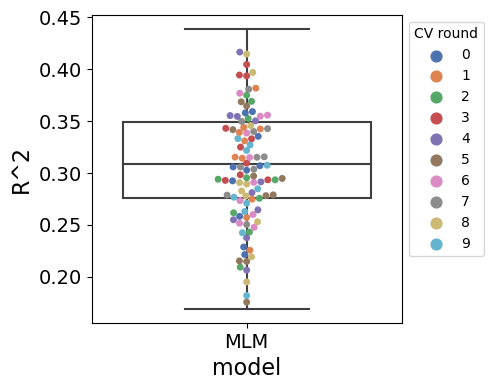

In [34]:
fig, ax = plt.subplots(figsize=(4,4))

cv_scores['model'] = 'MLM'

ax = sns.swarmplot(data=cv_scores[cv_scores['CV round']<10],y='score',x='model',hue="CV round", palette="deep")
ax = sns.boxplot(data=cv_scores,y='score',x='model', boxprops={'facecolor':'None'})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

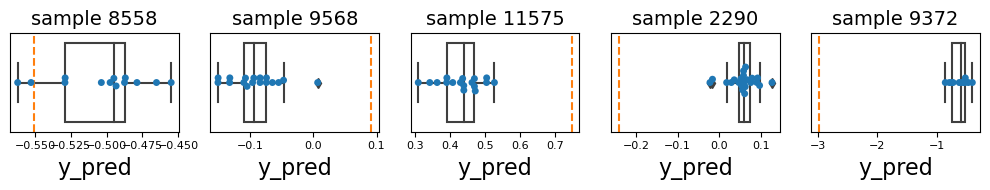

In [37]:
fig, axes = plt.subplots(1,5, figsize=(10,2))

axes = axes.flatten()

samples = np.random.choice(a=range(len(y)),size=5) #choose 5 random test points

for ax,sample_idx in zip(axes,samples):
    #sns.kdeplot(x=cv_res[:,sample_idx], ax=ax)
    sns.swarmplot(x=cv_res[:,sample_idx], ax=ax)
    sns.boxplot(x=cv_res[:,sample_idx], ax=ax, boxprops={'facecolor':'None'})
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.tick_params(axis='x', which='major', labelsize=8)
    ylims = ax.get_ylim()
    ax.plot(y[sample_idx]*np.ones((50,)),np.linspace(*ylims), linestyle='--', color='tab:orange') #y_true
    ax.set_title(f'sample {sample_idx}')
    ax.set_xlabel('y_pred')
    
fig.tight_layout()

<span style="color:coral">Q: How would you measure model instability?</span>


In [38]:
cv = np.nanstd(cv_res,axis=0)/np.nanmean(cv_res,axis=0) #coefficient of variation of each test point due to change in train set distribution

In [39]:
abs(cv).mean() #measure of model instability

1.6282482445961466

When choosing models, we prefer stable ones.

How to fight instability?

- add regularization
- use stable algorithms
- reduce the number of features through feature engineering

How to estimate generalization performance of an unstable model?

In [40]:
score_per_round = cv_scores.groupby('CV round')['score'].mean()#mean score in each round

CV_rounds = np.arange(1,N_rounds+1)

average_score = np.cumsum(score_per_round)/CV_rounds #cumulative average

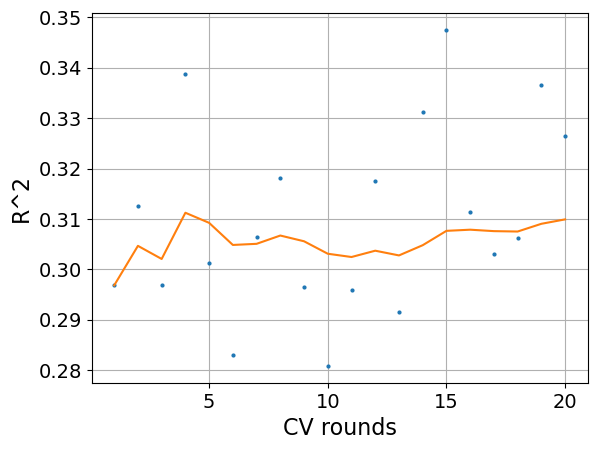

In [41]:
fig, ax = plt.subplots()

ax.plot(CV_rounds, score_per_round, marker='o', markersize=2, linestyle='') 

ax.plot(CV_rounds, average_score, markersize=2) 

ax.set_xlabel('CV rounds')
ax.set_ylabel('score')
ax.grid()

To estimate generalization performance of an unstable model, one performs repeated K-fold CV. The score is then averaged over all folds and all rounds. The number of repeats can be determined by plotting the averaged performance metric vs the number of rounds.